## Q-Network for optimal path finding

The main objective of Q-training is to develope a policy **π**  for navigating the maze successfully.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random, csv
import numpy as np
import pandas as pd
#from numpy import genfromtxt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import ELU
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Loading of input data, setting of hyperparameters and other variables for Q-learning

In [2]:
wd = 'C:\\Users\\homeuser\\Documents\\MEJ\\City MSc\\09DISSERTATION\\Report\\PicturesRawData\\RL\\'
visited_mark = 0.8  # Cells visited by the agent will be painted by gray 0.8
agent_mark = 0.5      # The current agent cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3
classes = np.arange(6)
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}# Actions dictionary
num_actions = len(actions_dict)
epsilon = 0.9# Exploration factor for Q-learning
alpha = 1#Learning rate for Q-learning
gamma = 0.9#Discount rate for Q-learning
targetCell = (5,5)
decrementRate = 0.1
lr = 0.01#Learning rate for neural network
envFileName = 'Environment.csv'
rewardFileName = 'RewardComputation.csv'
environment = pd.read_csv(wd+envFileName)
rewardMatrix = pd.read_csv(wd+rewardFileName)
env = np.array(environment)

**Reinforcement Learning **

### Qmaze class

In [3]:
# Environment is a 2d Numpy array; agent = (row, col) initial agent position (defaults to (0,0))
class Qmaze(object):
    def __init__(self, maze, agent=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell
        #self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] in classes]
        self.free_cells.remove(self.target)
        self.reset(agent)

    def reset(self, agent):
        self.agent = agent
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = agent
        self.maze[row, col] = agent_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = agent_row, agent_col, mode = self.state

        #if self.maze[agent_row, agent_col] > 0.0:
        self.visited.add((agent_row, agent_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in agent position
            mode = 'invalid'

        self.state = (nrow, ncol, nmode)# new state

        currClass = self.maze[agent_row, agent_col]  
        nextClass = self.maze[nrow, ncol]      
        return currClass,nextClass

    def class_reward(self, sourceId, targetId):
        temp = rewardMatrix[rewardMatrix['SourceID'] == sourceId]
        reward = temp[temp['TargetID']==targetId]['Cost'].iloc[0]
        return reward            

    def get_reward(self):
        agent_row, agent_col, mode = self.state
        nrows, ncols = self.maze.shape
        if agent_row == targetCell[0] and agent_col == targetCell[1]:
            return 1.0
        #if mode == 'blocked':
        #    return self.min_reward - 1
        if (agent_row, agent_col) in self.visited:
            return -0.25
        #if mode == 'invalid':
        #    return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        currentClass, targetClass = self.update_state(action)
        reward = float(self.get_reward()+ self.class_reward(currentClass, targetClass))
        self.total_reward = self.total_reward + alpha*reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the agent
        row, col, valid = self.state
        canvas[row, col] = agent_mark
        return canvas

    def game_status(self):
        agent_row, agent_col, mode = self.state
        nrows, ncols = self.maze.shape
        r,c=targetCell
        if agent_row == r and agent_col == c:
            return 'win'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    agent_row, agent_col, _ = qmaze.state
    canvas[agent_row, agent_col] = 0.3   # start cell
    canvas[nrows-1, ncols-1] = 0.9 # target cell
    img = plt.imshow(canvas, interpolation='none', cmap='jet')    
    return img

#### Display of environment

reward= 2.96


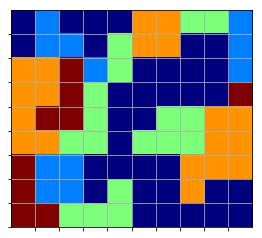

In [5]:
qmaze = Qmaze(env)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

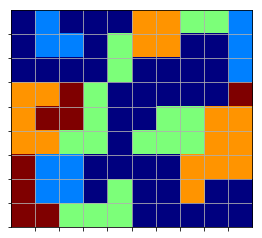

In [6]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

Function that simulates state transitions

In [7]:
def play_game(model, qmaze, agent_cell):
    qmaze.reset(agent_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

### Bellman Equation

In [8]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, alpha, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = alpha * ((reward + self.discount * Q_sa)-reward)
        return inputs, targets

### Q-Learning

In [9]:
def qtrain(model, maze, n_epoch=10, max_memory=100, data_size=32, **opt):
    global epsilon
    global alpha
    #weights_file = opt.get('weights_file', "")#Use pre-trained model by providing h5 file name to weights_file option
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()
    #if weights_file:
        #print("loading weights from file: %s" % (weights_file,))
        #model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory, discount=gamma)

    lossForAllEpochs = []
    rewardForAllEpochs = []

    for epoch in range(1,n_epoch+1):
        print("Epoch ==> ",epoch)
        lossOverEpisodes = []
        rewardOverEpisodes = []
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        game_over = False
        if (epoch%5 == 0):
            alpha = alpha - (decrementRate*alpha)
            epsilon = epsilon - (decrementRate*epsilon)

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            #currentRow, currentCol, mode = self.state
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                #win_history.append(1)
                game_over = True
            else:
                #win_history.append(0)#Newly added
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(alpha, data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)
            lossOverEpisodes.append(loss)
            rewardOverEpisodes.append(reward)
   
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | LR: {:.4f} | Exploration rate: {:.4f} | Final reward: {:.4f} | Final loss: {:.4f} | Training time: {}"
        print(template.format(epoch, n_epoch-1, alpha, epsilon, reward, loss, t))

        if game_status == 'win':
            print("Reached target in: [", n_episodes, "] episodes in epoch: [", epoch,"]")

    lossForAllEpochs.append(lossOverEpisodes)
    rewardForAllEpochs.append(rewardOverEpisodes)

    h5file = name + ".h5"# Save trained model weights and architecture
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))

    return lossForAllEpochs

def format_time(seconds):#Time formatting
    if seconds < 400:
        s = float(seconds)
        return "%.1f sec" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f min" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hr" % (h,)

### ANN approach
    1) Activation function is ELU (Exponential relu)
    2) Optimizer is Adam
    3) Loss function is MSE (Mean Squared Error)

In [11]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(ELU(lr))
    model.add(Dense(maze.size))
    model.add(ELU(lr))
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

#### Q-test

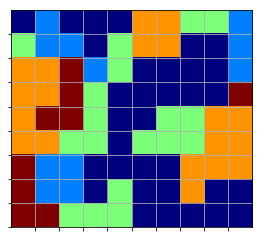

In [ ]:
qmaze = Qmaze(env)
show(qmaze)

#### Q-network training

In [ ]:
model = build_model(env)
trainingLoss = qtrain(model, env, 8, max_memory=1*env.size, data_size=32)

Epoch ==>  1
Epoch: 001/7 | LR: 1.0000 | Exploration rate: 0.9000 | Final reward: 4.0000 | Final loss: 0.7557 | Training time: 0.7 sec
Reached target in: [ 1 ] episodes in epoch: [ 1 ]
Epoch ==>  2
Epoch: 002/7 | LR: 1.0000 | Exploration rate: 0.9000 | Final reward: 3.5000 | Final loss: 0.0001 | Training time: 17.4 sec
Reached target in: [ 402 ] episodes in epoch: [ 2 ]
Epoch ==>  3
Epoch: 003/7 | LR: 1.0000 | Exploration rate: 0.9000 | Final reward: 3.5000 | Final loss: 0.0523 | Training time: 60.9 sec
Reached target in: [ 1019 ] episodes in epoch: [ 3 ]
Epoch ==>  4
Epoch: 004/7 | LR: 1.0000 | Exploration rate: 0.9000 | Final reward: 3.5000 | Final loss: 0.0005 | Training time: 96.3 sec
Reached target in: [ 797 ] episodes in epoch: [ 4 ]
Epoch ==>  5
